## Dataset Lenght of Stay

Il dataset che abbiamo scelto per il nostro task contiene 100.000 records ognuno dei quali è relativo al ricovero ospedaliero di un paziente.
Gli attributi considerati sono in parte relativi all'identità del paziente, e in parte alla sua condizione clinica e sanitaria. 

È interessante osservare la distribuzione dei diversi attributi.
Un fatto immediatamente evidente è lo sbilanciamento delle etichette di classe: la maggior parte delle durate di ricovero sono inferiori alla metà del valore massimo.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split   #funzioni per dividere il dataset in test/validation/training set
import datetime #fornisce funzioni e classi per lavorare con date e tempi
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator #strumento di visualizzazione per l’esplorazione dei dati
from IPython.core.display import display, HTML #funzioni utilizzate per visualizzare output HTML nel notebook
import base64 #fornisce funzioni per codificare e decodificare dati binari in stringhe ASCII utilizzando la codifica base64
pd.set_option('future.no_silent_downcasting', True)     # Consente che si possa cambiare il tipo degli attributi nel dataset, servirà in fase di preprocessing


C:\Users\gobba\AppData\Local\Temp\ipykernel_20756\788373187.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML #funzioni utilizzate per visualizzare output HTML nel notebook


Importando il dataset e visualizzando i primi record ci accorgiamo che ci sono degli attributi data, questi non possono essere elaborati direttamente da Tensorflow ma vanno preprocessati e convertiti in valori numerici.
Assegnamo ad ogni data il corrispondente giorno dell'anno da 1 a 365 (o 366 se l'anno e bisestile)

In [2]:
df = pd.read_csv("LengthOfStay.csv") #carica il dataframe in una variabile struttando pandas

Sistemate le date, gli altri attributi a cui dovremo dare una codifica numerica sono:
- rcount: trasformeremo il valore 5+ in 5
- gender: trasformeremo M in 0 ed F 1
- facid: trasformeremo le lettere in numeri incrementali


In [3]:
test_ratio = 0.15
val_ratio = 0.15
data_len = len(df)

train_bound = int(data_len*(1-val_ratio-test_ratio))
val_bound = int(data_len*(1-test_ratio))

df_features = df.iloc[:, 1:-1]
df_labels = df.iloc[:, -1]

x_train, y_train = df_features[:train_bound], df_labels[:train_bound]

In [4]:
fsg = FeatureStatisticsGenerator() #Crea un oggetto FeatureStatisticsGenerator, che è una classe di Facets che genera statistiche dai tuoi dati
dataframes = [ {'table': pd.concat([x_train, y_train], axis=1), 'name': 'trainData'}] #Crea un dizionario con dentro il dataframe
censusProto = fsg.ProtoFromDataFrames(dataframes) # Genera le statistiche dal DataFrame
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8") # codifica dei dati del dataset

# Impostazioni per la visualizzazione (mostra degli attributi evidentemente sbilanciati)
HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script> <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html"> <facets-overview id="elem"></facets-overview> <script> document.querySelector("#elem").protoInput = "{protostr}"; </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

c:\Users\gobba\miniconda3\envs\kambinete\lib\site-packages\facets_overview\base_generic_feature_statistics_generator.py:121: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  flattened = x.ravel()


A questo punto il dataset ha solamente valori numerici e può essere trattato come un tensore.
Sappiamo che le reti neurali necessitano che i tensori da esse elaborati contengano valori tra 0 e 1, dunque è opportuno standardizzare i dati

In [5]:
dates = df["vdate"]     # Date originali
encoded_dates = [datetime.datetime.strptime(str(date), "%m/%d/%Y").timetuple().tm_yday for date in dates] # Date codificate 
encoding_dict = dict(zip(dates, encoded_dates))     # Creazione dizionario di codifica per le date
df.replace({"vdate": encoding_dict}, inplace=True)  # Sostituzione nella colonna

dates = df["discharged"]
encoded_dates = [datetime.datetime.strptime(str(date), "%m/%d/%Y").timetuple().tm_yday for date in dates]
encoding_dict = dict(zip(dates, encoded_dates))
df.replace({"discharged": encoding_dict}, inplace=True)

df.replace({"rcount": dict(zip(sorted(df["rcount"].unique()), range(6)))}, inplace=True)   # Codifica del 5+ in 5 e conversione a interi

df.replace({"gender": "M"}, 0, inplace=True)    # Codifica binaria del genere, assegna 0 a maschio e 1 a femmina
df.replace({"gender": "F"}, 1, inplace=True)

keys = df["facid"].unique()                        # Estrazione dei valori unici dell'attributo
ints = {key: value for value, key in enumerate(keys)}    # Creazione del dizionario di codifica

df.replace({"facid": ints}, inplace=True)                # Codifica del facid

In [6]:
dataset = df.to_numpy() #Converte il dataframe in un array numpy

#divide le colonne del dataset in attributi e label
features = dataset[:, 1:-1]
labels = dataset[:, -1]

#funzione che standardizza i dati nel range [0,1] e li rende di tipo float32
def standardize(dataset: np.ndarray) -> tf.Tensor:
    for i in range(dataset.shape[1]):
        column = dataset[:, i]
        dataset[:, i] = (column - np.min(column)) / (np.max(column) - np.min(column))
    return tf.convert_to_tensor(dataset, dtype=tf.float32)

features = standardize(features) #standardizza i dati nel range [0,1]

#divide i dati in dati in train, validazione e test set
x_train, y_train = features[:train_bound], labels[:train_bound]
x_val, y_val = features[train_bound:val_bound], features[train_bound:val_bound]
x_test, y_test = features[val_bound:], labels[val_bound:]

print(tf.shape(x_train), tf.shape(x_val), tf.shape(x_test)) #stampa le dimensini dei nuovi dataset creati


tf.Tensor([70000    26], shape=(2,), dtype=int32) tf.Tensor([15000    26], shape=(2,), dtype=int32) tf.Tensor([15000    26], shape=(2,), dtype=int32)


In [52]:
import tensorflow as tf
from tfkan.layers import DenseKAN
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt


In [95]:

tf.random.set_seed(420)

class RootMeanSquaredError(tf.keras.metrics.Metric):
    def __init__(self, name='rmse', **kwargs):
        super(RootMeanSquaredError, self).__init__(name=name, **kwargs)
        self.mse = tf.keras.metrics.MeanSquaredError(name='mse')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.mse.update_state(y_true, y_pred, sample_weight)
        
    def result(self):
        return tf.sqrt(self.mse.result())
        
    def reset_states(self):
        self.mse.reset_states()


# Lista di metrics necessarie per valutare le performance.
METRICS = [
  tf.keras.metrics.MeanSquaredError(name='mse'),
  tf.keras.metrics.MeanAbsoluteError(name='mae'),
  tf.keras.metrics.RootMeanSquaredError(name='rmse')
]

# Parametri gestibili da interfaccia
HIDDEN_UNITS_LAYER_01 = 8 #@param
HIDDEN_UNITS_LAYER_02 = 1 #@param
LEARNING_RATE = 0.01 #@param

# Creazione del modello KAN
kan = tf.keras.models.Sequential([
    DenseKAN(HIDDEN_UNITS_LAYER_01),
    DenseKAN(HIDDEN_UNITS_LAYER_02)
])
kan.build(input_shape=(None, 26))
kan.summary()



Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_kan_26 (DenseKAN)         │ (None, 8)              │         1,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_27 (DenseKAN)         │ (None, 1)              │            73 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,953 (7.63 KB)

 Trainable params: 1,953 (7.63 KB)

 Non-trainable params: 0 (0.00 B)

In [96]:
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

tf.random.set_seed(420)

def rmse(y_true, y_pred):
    return tf.sqrt(tf.keras.losses.MSE(y_true, y_pred))

kan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), loss='mse', metrics=[rmse, 'mae'])

kan_history = kan.fit(x_train, y_train, epochs=500, batch_size=128, validation_data=(x_test, y_test), verbose=1)


Epoch 1/500
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 5.9938 - mae: 1.7914 - rmse: 1.7914 - val_loss: 1.0940 - val_mae: 0.8012 - val_rmse: 0.8012
Epoch 2/500
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0007 - mae: 0.7489 - rmse: 0.7489 - val_loss: 0.7688 - val_mae: 0.6262 - val_rmse: 0.6262
Epoch 3/500
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7431 - mae: 0.6164 - rmse: 0.6164 - val_loss: 0.6758 - val_mae: 0.5837 - val_rmse: 0.5837
Epoch 4/500
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6734 - mae: 0.5840 - rmse: 0.5840 - val_loss: 0.6366 - val_mae: 0.5646 - val_rmse: 0.5646
Epoch 5/500
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6408 - mae: 0.5687 - rmse: 0.5687 - val_loss: 0.6086 - val_mae: 0.5508 - val_rmse: 0.5508
Epoch 6/500
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6173 - mae: 0.5580 - rmse: 0.5580 - val_loss: 0.5887 - val_mae: 0.5415 - val_rmse: 0.5415
Epoch 7/500
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6003 - mae: 0.5502 

In [67]:
# MLP
mlp = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
mlp.build(input_shape=(None, 26))
mlp.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 64)             │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,793 (7.00 KB)

 Trainable params: 1,793 (7.00 KB)

 Non-trainable params: 0 (0.00 B)

In [98]:

mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mse', metrics=[rmse, 'mae'])

mlp_history = mlp.fit(x_train, y_train, epochs=500, batch_size=128, validation_data=(x_test, y_test), verbose=1)

Epoch 1/500
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 823us/step - loss: 0.6884 - mae: 0.6058 - rmse: 0.6058 - val_loss: 0.8476 - val_mae: 0.7179 - val_rmse: 0.7179
Epoch 2/500
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - loss: 0.6815 - mae: 0.6009 - rmse: 0.6009 - val_loss: 0.8489 - val_mae: 0.7212 - val_rmse: 0.7212
Epoch 3/500
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 0.6852 - mae: 0.6034 - rmse: 0.6034 - val_loss: 0.7095 - val_mae: 0.6279 - val_rmse: 0.6279
Epoch 4/500
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 0.6752 - mae: 0.5988 - rmse: 0.5988 - val_loss: 0.6810 - val_mae: 0.5894 - val_rmse: 0.5894
Epoch 5/500
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 0.6618 - mae: 0.5925 - rmse: 0.5925 - val_loss: 0.6880 - val_mae: 0.5858 - val_rmse: 0.5858
Epoch 6/500
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - loss: 0.6585 - mae: 0.5909 - rmse: 0.5909 - val_loss: 0.6996 - val_mae: 0.5851 - val_rmse: 0.5851
Epoch 7/500
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 0.6543 

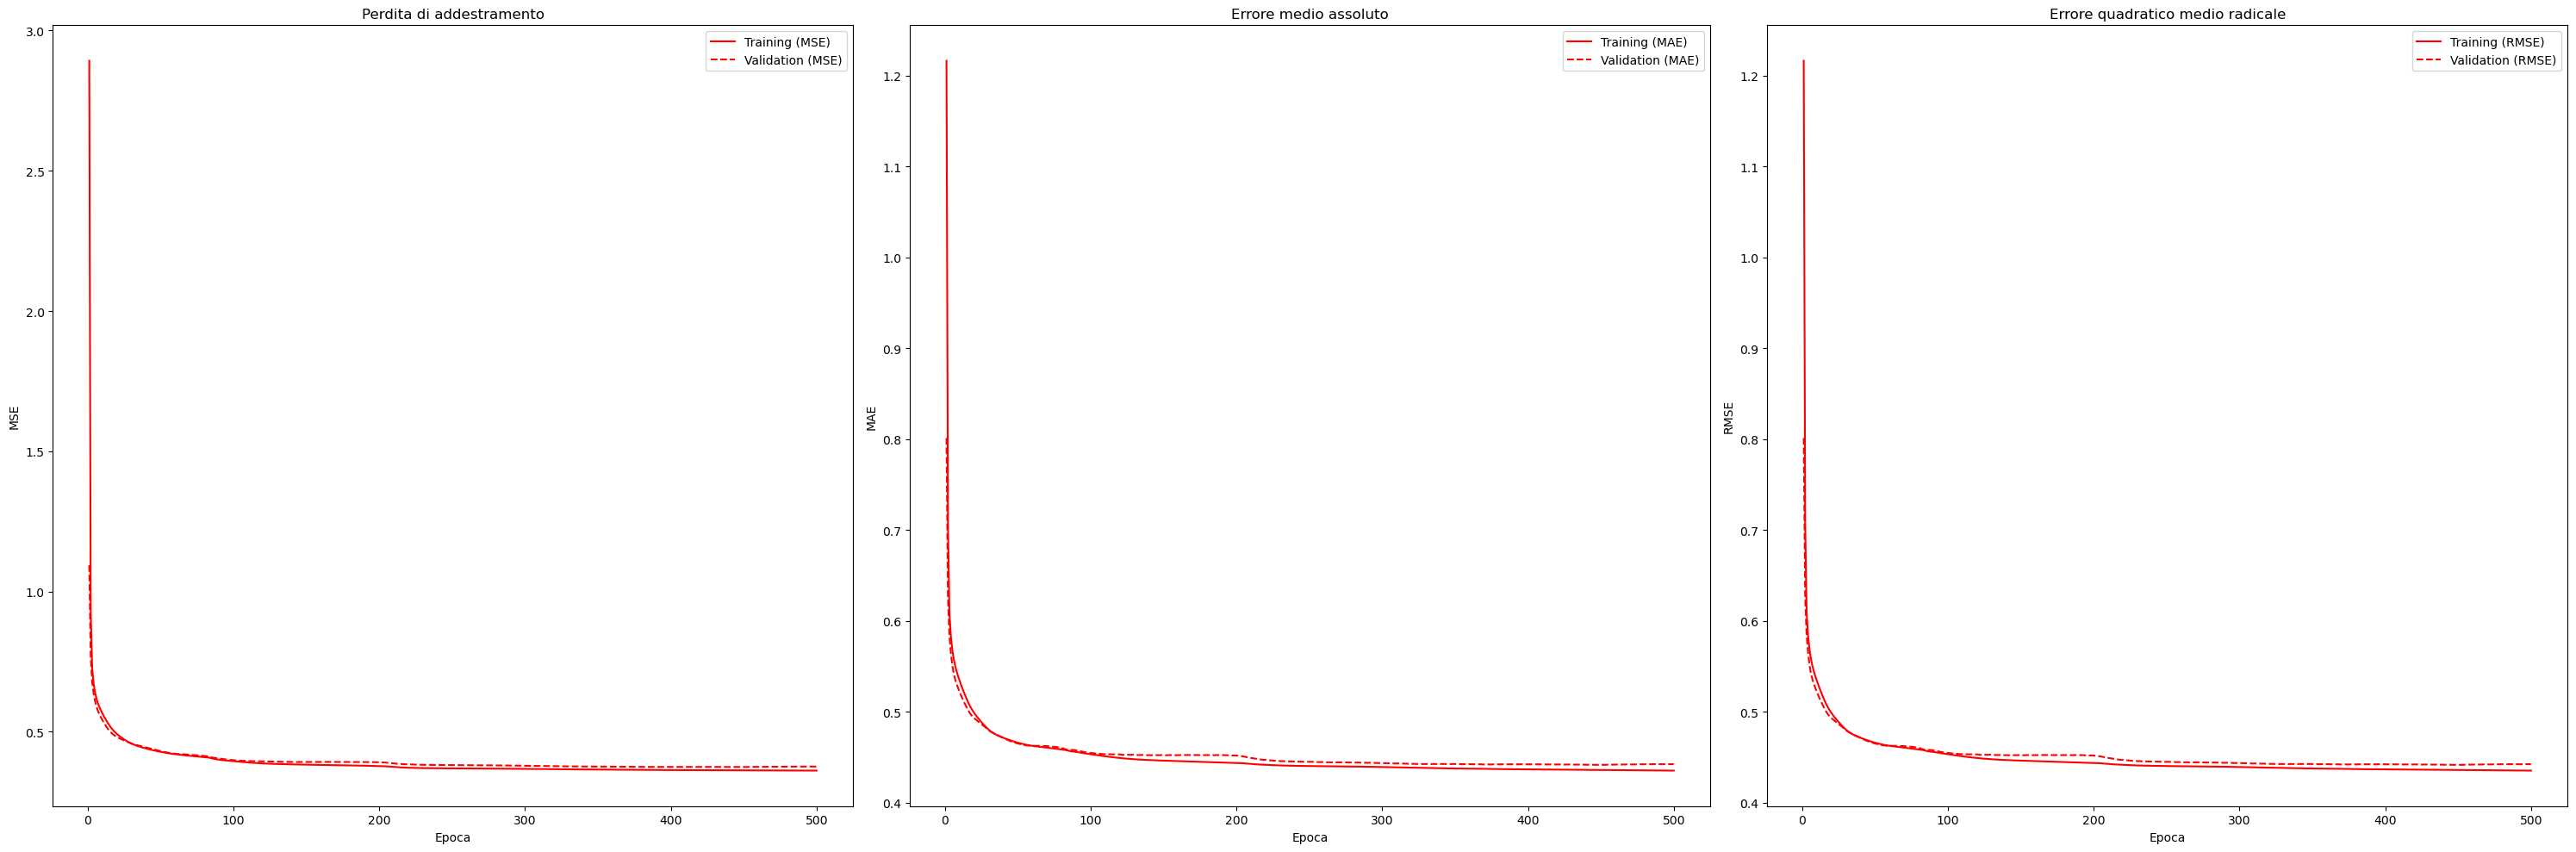

In [101]:
import matplotlib.pyplot as plt

# Supponiamo che 'kan_history' sia il risultato del tuo modello.fit()
loss = kan_history.history['loss']
val_loss = kan_history.history['val_loss']
mae = kan_history.history['mae']
val_mae = kan_history.history['val_mae']
rmse = kan_history.history['rmse']
val_rmse = kan_history.history['val_rmse']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
plt.plot(epochs, loss, 'r', label='Training (MSE)') # linea rossa per training
plt.plot(epochs, val_loss, 'r--', label='Validation (MSE)') # linea tratteggiata rossa per validation
plt.title('Perdita di addestramento')
plt.xlabel('Epoca')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, mae, 'r', label='Training (MAE)') # linea rossa per training
plt.plot(epochs, val_mae, 'r--', label='Validation (MAE)') # linea tratteggiata rossa per validation
plt.title('Errore medio assoluto')
plt.xlabel('Epoca')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, rmse, 'r', label='Training (RMSE)') # linea rossa per training
plt.plot(epochs, val_rmse, 'r--', label='Validation (RMSE)') # linea tratteggiata rossa per validation
plt.title('Errore quadratico medio radicale')
plt.xlabel('Epoca')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()


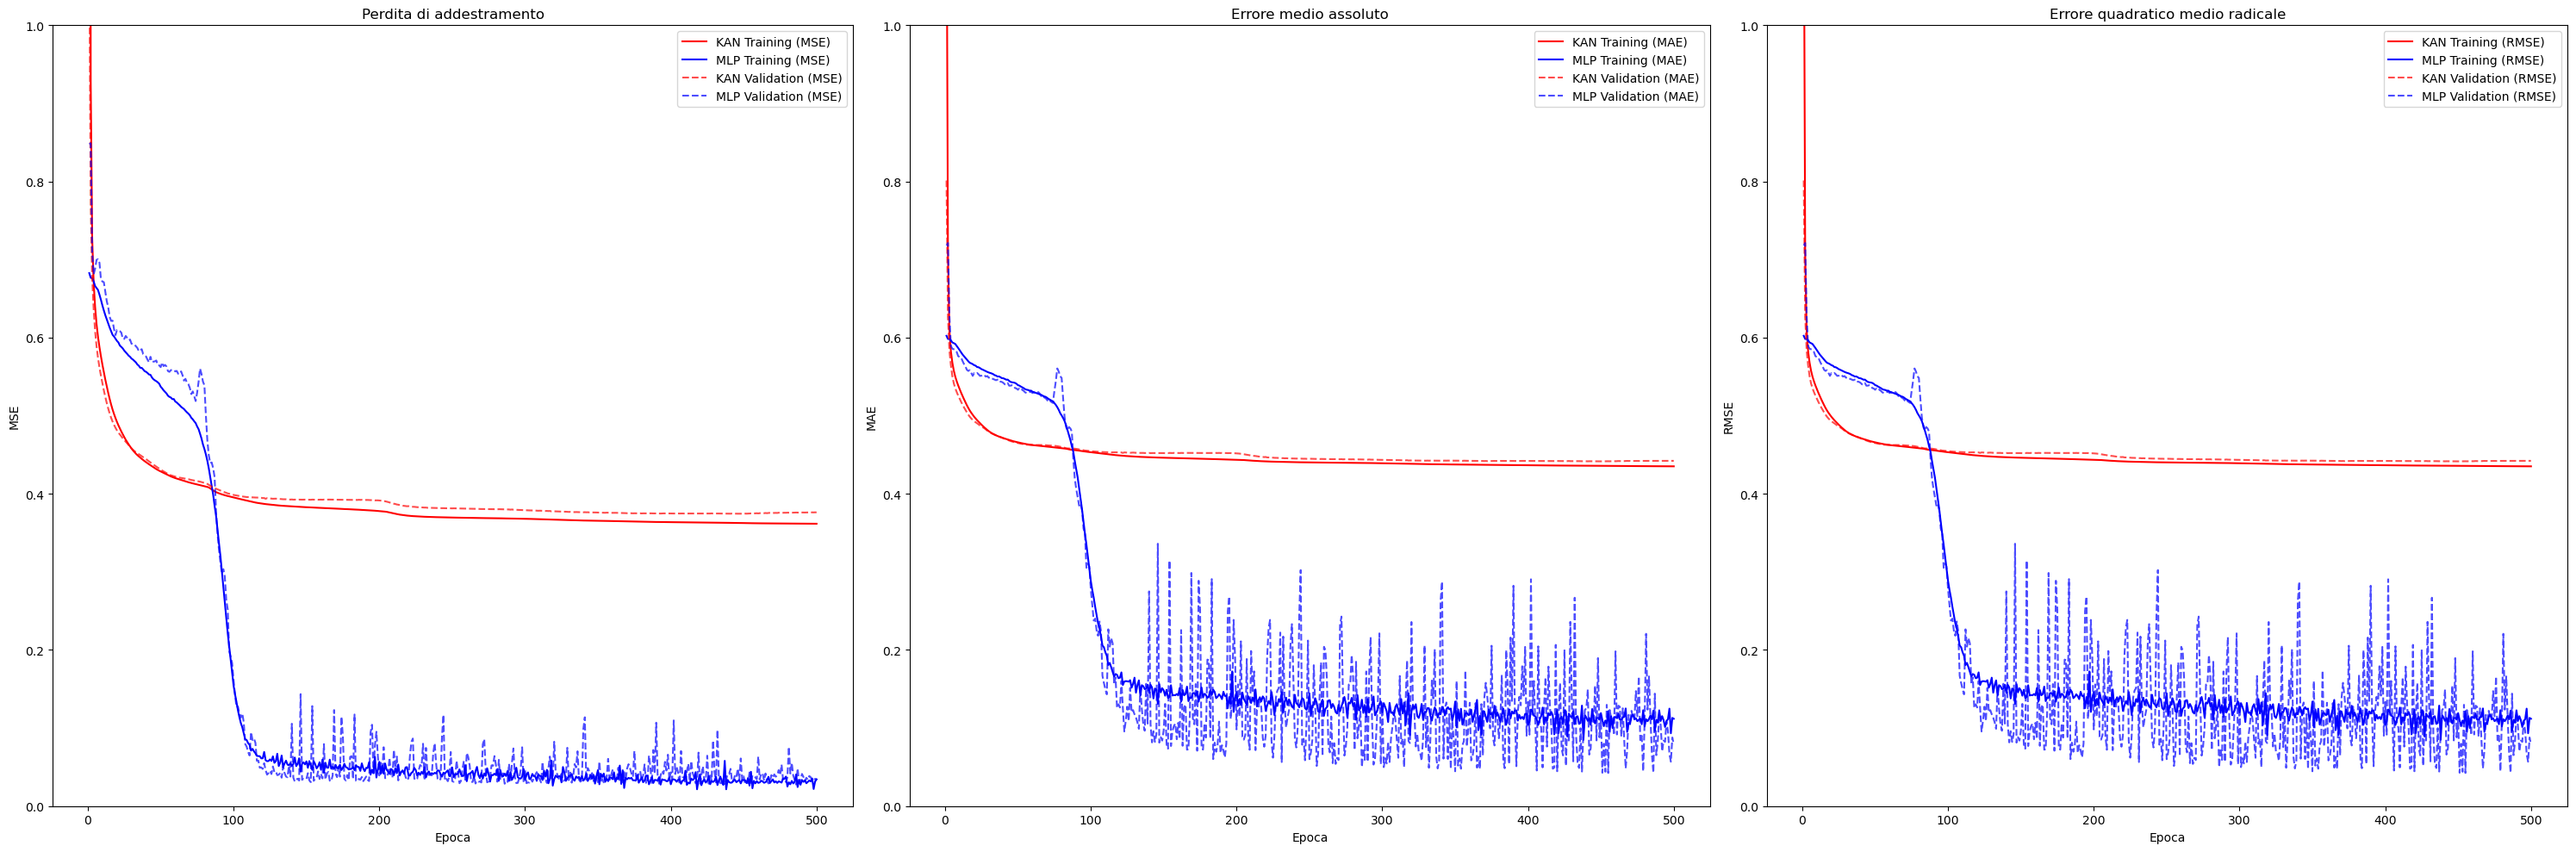

In [100]:
import matplotlib.pyplot as plt

# Supponiamo che 'kan_history' e 'mlp_history' siano i risultati del tuo modello.fit()
kan_loss = kan_history.history['loss']
kan_val_loss = kan_history.history['val_loss']
kan_mae = kan_history.history['mae']
kan_val_mae = kan_history.history['val_mae']
kan_rmse = kan_history.history['rmse']
kan_val_rmse = kan_history.history['val_rmse']

mlp_loss = mlp_history.history['loss']
mlp_val_loss = mlp_history.history['val_loss']
mlp_mae = mlp_history.history['mae']
mlp_val_mae = mlp_history.history['val_mae']
mlp_rmse = mlp_history.history['rmse']
mlp_val_rmse = mlp_history.history['val_rmse']

epochs = range(1, len(kan_loss) + 1)

plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
plt.plot(epochs, kan_loss, 'r', label='KAN Training (MSE)') # linea rossa per KAN
plt.plot(epochs, mlp_loss, 'b', label='MLP Training (MSE)') # linea blu per MLP
plt.plot(epochs, kan_val_loss, 'r--', alpha=0.7, label='KAN Validation (MSE)') # linea tratteggiata rossa per KAN validation
plt.plot(epochs, mlp_val_loss, 'b--', alpha=0.7, label='MLP Validation (MSE)') # linea tratteggiata blu per MLP validation
plt.title('Perdita di addestramento')
plt.xlabel('Epoca')
plt.ylabel('MSE')
plt.ylim([0, 1])  # Imposta il range dell'asse y
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, kan_mae, 'r', label='KAN Training (MAE)') # linea rossa per KAN
plt.plot(epochs, mlp_mae, 'b', label='MLP Training (MAE)') # linea blu per MLP
plt.plot(epochs, kan_val_mae, 'r--', alpha=0.7, label='KAN Validation (MAE)') # linea tratteggiata rossa per KAN validation
plt.plot(epochs, mlp_val_mae, 'b--', alpha=0.7, label='MLP Validation (MAE)') # linea tratteggiata blu per MLP validation
plt.title('Errore medio assoluto')
plt.xlabel('Epoca')
plt.ylabel('MAE')
plt.ylim([0, 1])  # Imposta il range dell'asse y
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, kan_rmse, 'r', label='KAN Training (RMSE)') # linea rossa per KAN
plt.plot(epochs, mlp_rmse, 'b', label='MLP Training (RMSE)') # linea blu per MLP
plt.plot(epochs, kan_val_rmse, 'r--', alpha=0.7, label='KAN Validation (RMSE)') # linea tratteggiata rossa per KAN validation
plt.plot(epochs, mlp_val_rmse, 'b--', alpha=0.7, label='MLP Validation (RMSE)') # linea tratteggiata blu per MLP validation
plt.title('Errore quadratico medio radicale')
plt.xlabel('Epoca')
plt.ylabel('RMSE')
plt.ylim([0, 1])  # Imposta il range dell'asse y
plt.legend()

plt.tight_layout()
plt.show()


In [102]:
# Definizione delle categorie e sottogruppi
CATEGORY = 2  # indice dell'attributo "gender" nel tuo dataset
SUBGROUPS = [0, 1]  # 0 per maschio, 1 per femmina

# Creazione di un dizionario per memorizzare i risultati
results = {}

for sg in SUBGROUPS: #per ogni gruppo nell'elenco dei sottogruppi
    
    # Filtraggio del dataset di test per il sottogruppo corrente
    subgroup_indices = x_test[:, CATEGORY] == sg
    features = x_test[subgroup_indices]
    labels = y_test[subgroup_indices]
    
    # Calcolo delle previsioni del modello sul sottogruppo corrente
    predictions = kan.predict(features)
    
    # Calcolo delle metriche personalizzate per ciascun sottogruppo
    mse_value = tf.keras.metrics.MeanSquaredError()(labels, predictions).numpy()
    mae_value = tf.keras.metrics.MeanAbsoluteError()(labels, predictions).numpy()
    rmse_value = tf.sqrt(mse_value)
    
    # Memorizzazione dei risultati
    results[sg] = [mse_value, mae_value, rmse_value]

# Creazione di un DataFrame per visualizzare le metriche di performance
performance_df = pd.DataFrame(results, index=['MSE', 'MAE', 'RMSE'])
pd.options.display.float_format = '{:,.4f}'.format  # Formattazione float per il DataFrame

# Stampa delle metriche di performance
print(performance_df)


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step
                                                  0  \
MSE                                          0.4161   
MAE                                          0.4636   
RMSE  tf.Tensor(0.6450634, shape=(), dtype=float32)   

                                                  1  
MSE                                          0.3444  
MAE                                          0.4252  
RMSE  tf.Tensor(0.5868695, shape=(), dtype=float32)  


In [107]:
# Definizione delle categorie e sottogruppi
CATEGORY = 2  # indice dell'attributo "gender" nel tuo dataset
SUBGROUPS = [0, 1]  # 0 per maschio, 1 per femmina

# Creazione di un dizionario per memorizzare i risultati
mlp_results = {}

for sg in SUBGROUPS: #per ogni gruppo nell'elenco dei sottogruppi
    
    # Filtraggio del dataset di test per il sottogruppo corrente
    subgroup_indices = x_test[:, CATEGORY] == sg
    features = x_test[subgroup_indices]
    labels = y_test[subgroup_indices]
    
    # Calcolo delle previsioni del modello sul sottogruppo corrente
    predictions = mlp.predict(features)
    
    # Calcolo delle metriche personalizzate per ciascun sottogruppo
    mse_value = tf.keras.metrics.MeanSquaredError()(labels, predictions).numpy()
    mae_value = tf.keras.metrics.MeanAbsoluteError()(labels, predictions).numpy()
    rmse_value = tf.sqrt(mse_value)
    
    # Memorizzazione dei risultati
    mlp_results['Maschio' if sg == 0 else 'Femmina'] = [mse_value, mae_value, rmse_value]

# Creazione di un DataFrame per visualizzare le metriche di performance
mlp_performance_df = pd.DataFrame(mlp_results, index=['MSE', 'MAE', 'RMSE'])
pd.options.display.float_format = '{:,.4f}'.format  # Formattazione float per il DataFrame

# Stampa delle metriche di performance
print(mlp_performance_df)


208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step
                                             Maschio  \
MSE                                           0.0320   
MAE                                           0.0789   
RMSE  tf.Tensor(0.17900196, shape=(), dtype=float32)   

                                             Femmina  
MSE                                           0.0334  
MAE                                           0.0784  
RMSE  tf.Tensor(0.18269071, shape=(), dtype=float32)  


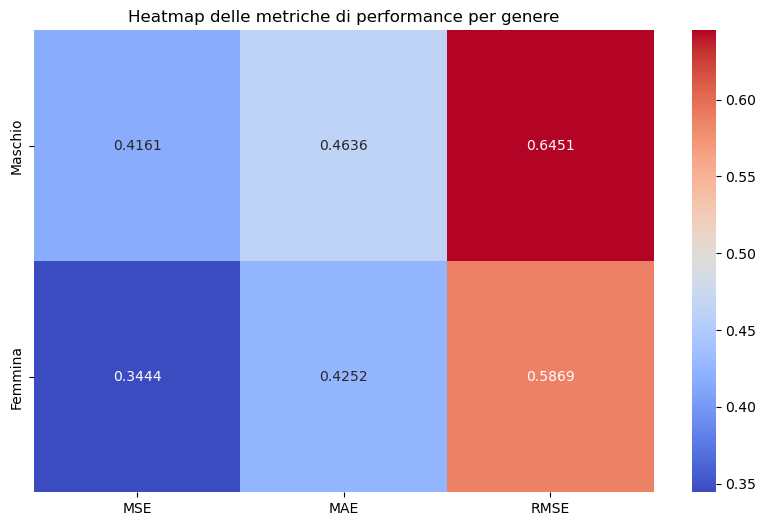

In [108]:
import seaborn as sns
import pandas as pd

# Creazione di un DataFrame per visualizzare le metriche di performance
performance_df = pd.DataFrame(results, index=['MSE', 'MAE', 'RMSE'])
performance_df.columns = ['Maschio', 'Femmina']

# Conversione dei dati in float
performance_df = performance_df.astype(float)

# Trasposizione del DataFrame per avere le metriche come colonne e i valori di genere come righe
performance_df = performance_df.transpose()

# Creazione della heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(performance_df, annot=True, cmap='coolwarm', fmt=".4f")
plt.title('Heatmap delle metriche di performance per genere')
plt.show()


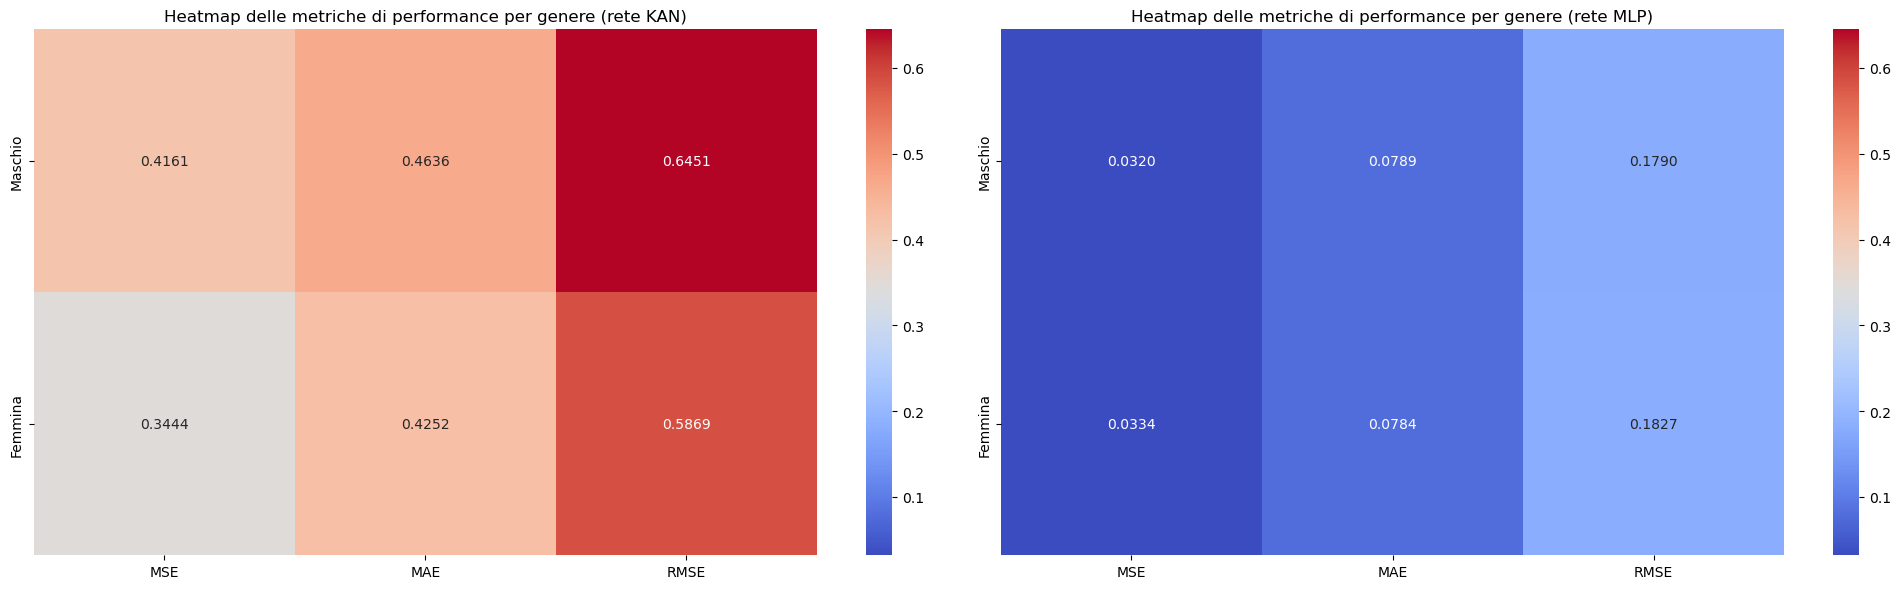

In [109]:
import seaborn as sns
import pandas as pd

# Creazione di un DataFrame per visualizzare le metriche di performance della rete KAN
kan_df = pd.DataFrame(results, index=['MSE', 'MAE', 'RMSE'])
kan_df.columns = ['Maschio', 'Femmina']

# Conversione dei dati in float
kan_df = kan_df.astype(float)
mlp_performance_df = mlp_performance_df.astype(float)

# Trasposizione dei DataFrame per avere le metriche come colonne e i valori di genere come righe
kan_df = kan_df.transpose()
mlp_performance_df = mlp_performance_df.transpose()

# Calcolo dei valori minimi e massimi per la scala di colori
vmin = min(kan_df.min().min(), mlp_performance_df.min().min())
vmax = max(kan_df.max().max(), mlp_performance_df.max().max())

# Creazione delle heatmap
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
sns.heatmap(kan_df, annot=True, cmap='coolwarm', fmt=".4f", vmin=vmin, vmax=vmax)
plt.title('Heatmap delle metriche di performance per genere (rete KAN)')

plt.subplot(1, 2, 2)
sns.heatmap(mlp_performance_df, annot=True, cmap='coolwarm', fmt=".4f", vmin=vmin, vmax=vmax)
plt.title('Heatmap delle metriche di performance per genere (rete MLP)')

plt.tight_layout()
plt.show()
